In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm
import pandas as pd

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 25  
plt.rcParams["xtick.labelsize"] = 20  
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.xmargin'] = 0.05

In [15]:
# generate theory (for now)

dj = {}
dj['p'] = dijet.DIJET(fit_type='pp', constrained_moments=True, IR_reg=['gauss', 0.4], nucleon='p')
dj['n'] = dijet.DIJET(fit_type='pp', constrained_moments=True, IR_reg=['gauss', 0.4], nucleon='n')

space = {
    'y' : [0.05, 0.95],
    'z' : [0.2, 0.5],
    'Q2': [16, 100],
    't': 0.1,
    'phi_Dp': [0, 2*np.pi],
    'phi_kp': [0, 2*np.pi]
}
np.linspace(2,5,7)
r0 = 0.5
roots = 50

npoints = 6
replica = 2
dj['p'].set_params(replica)
dj['n'].set_params(replica)

theory = {}

targets = ['p', 'd', 'h']
correlations = ['cos(phi_Dp)', 'cos(phi_Dp)cos(phi_kp)', 'sin(phi_Dp)sin(phi_kp)']

for tar in targets:
    theory[tar] = {}
    print(tar)
    
    denom = dj['p'].get_integrated_xsec(pT_values, roots**2, space, points=npoints, kind='den', r0=r0)
    for corr in correlations:
        
        num_p = dj['p'].get_integrated_xsec(pT_values, roots**2, space, weight=corr, points=npoints, kind='num', r0=r0)
        
        if tar in ['d', 'h']:
            num_n = dj['n'].get_integrated_xsec(pT_values, roots**2, space, weight=corr, points=npoints, kind='num', r0=r0)

            if tar == 'd':
                p,n = 1,1
                omega_d = 0.07
                Pp = 1-1.5*omega_d
                Pn = Pp
        
            elif tar == 'h':
                p,n = 2,1
                pS,pD,pSp = 0.9,0.1,0.02
                Pp = -(4./3.)*(pD-pSp)
                Pn = pS - (1./3.)*(pD-pSp)

            theory[tar][corr] = (Pp*num_p + Pn*num_n)/((p+n)*denom)
        else:
            theory[tar][corr] = num_p/denom


--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10_200reps.csv
--> loaded replica 1
--> !!! Using constrained moment parameters!
--> loaded unpol. amp. data from /dipoles/narr_ymin4.61_ymax14.91_AAMS09.dat
--> loaded pol. amp. data from /dipoles/d05-rc/
--> loaded params from /dipoles/replica_params_pp.csv
--> loaded random moment params from /dipoles/moment_params_pp_oam3_range10_200reps.csv
--> loaded replica 1
--> loaded replica 2
--> loaded replica 2
p
d
h


In [16]:
# plot pseudo-data

dfs = {}
dfs['p'] = pd.read_excel("1000.xlsx")
dfs['d'] = pd.read_excel("1001.xlsx")
dfs['h'] = pd.read_excel("1002.xlsx")
# dfs['p'] = pd.read_excel("2000.xlsx")
# dfs['d'] = pd.read_excel("2001.xlsx")
# dfs['h'] = pd.read_excel("2002.xlsx")

targets = ['p', 'd', 'h']
corrs = ['cos(phi_Dp)', 'cos(phi_Dp)cos(phi_kp)', 'sin(phi_Dp)sin(phi_kp)']

pT_values = dfs['p'][(dfs['p']['obs']==corrs[0])]['PT'].to_numpy()
data = {}
errs = {}
for tar in targets:
    data[tar] = {}
    errs[tar] = {}
    for corr in corrs:
        data[tar][corr] = dfs[tar][(dfs[tar]['obs']==corr)]['value'].to_numpy()
        stat_err = dfs[tar][(dfs[tar]['obs']==corr)]['stat_u'].to_numpy()
        sys_err = dfs[tar][(dfs[tar]['obs']==corr)]['sys_u'].to_numpy()
        errs[tar][corr] = np.sqrt(stat_err**2 + sys_err**2)
    

In [17]:
pT_values

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

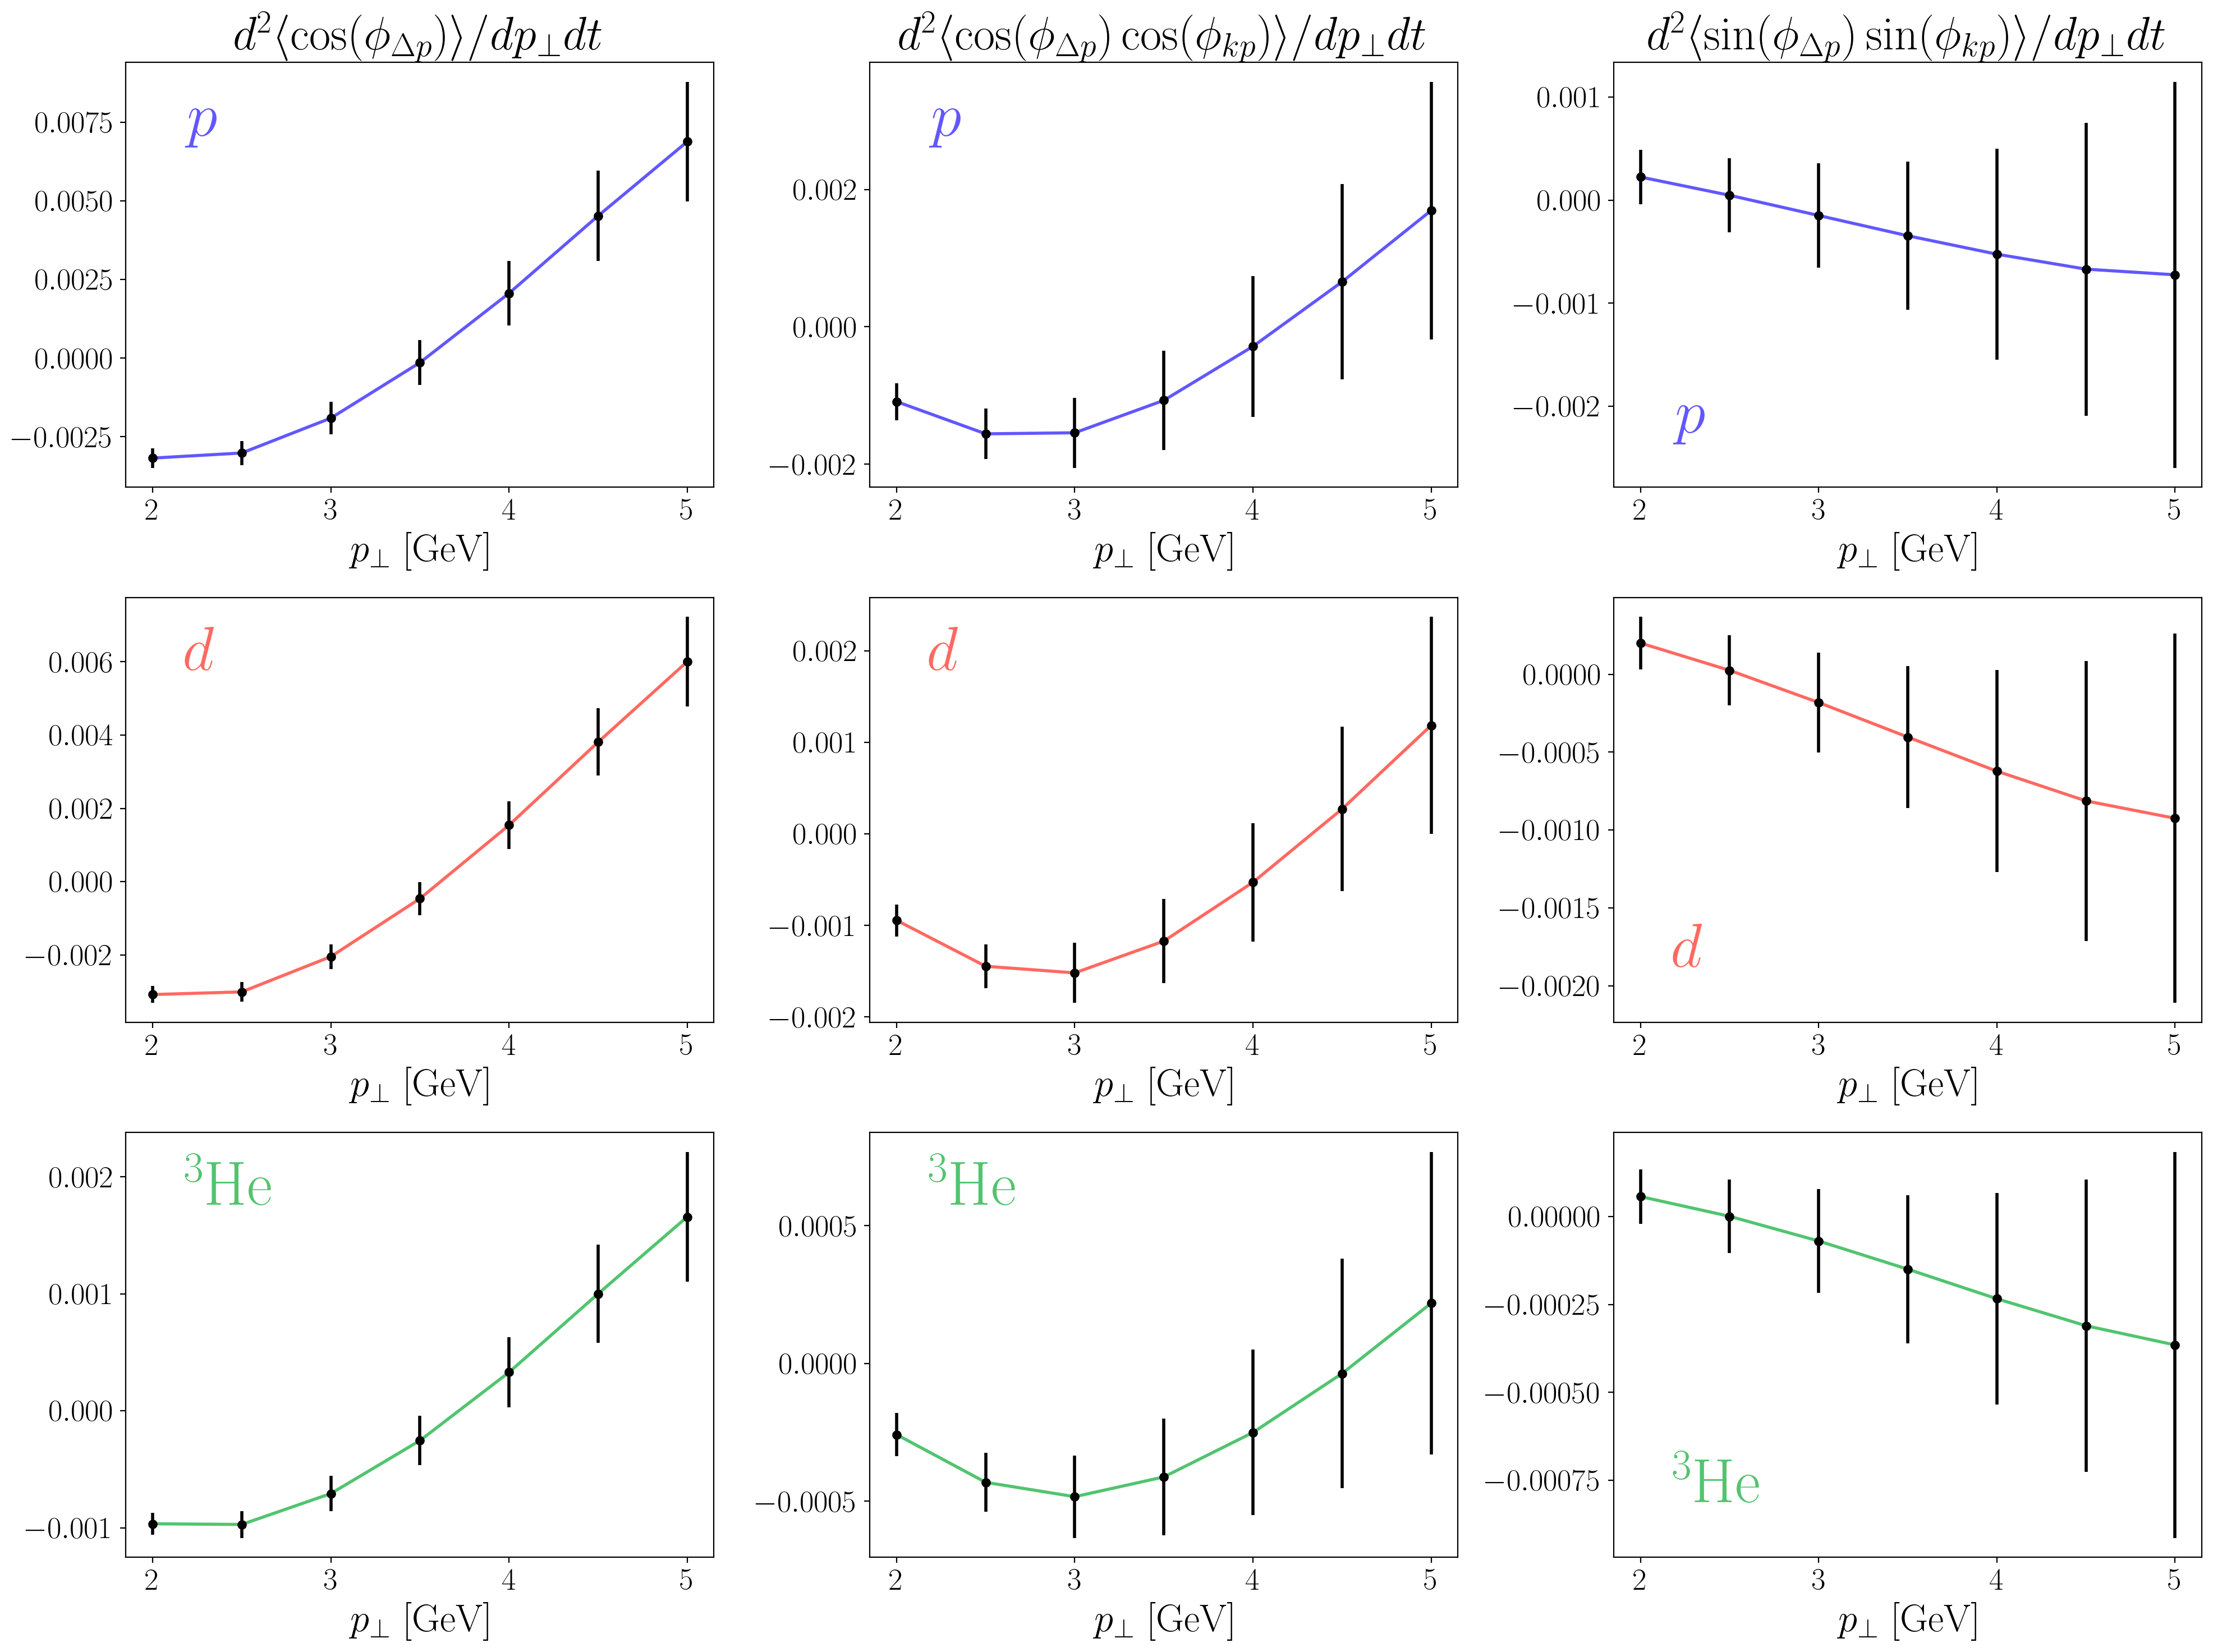

In [18]:
asp_ratio = 4/3
psize = 5

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))

save_plots = False
plot_bands = True
alt_defs = False
plot_stat_errors = True

colors = ['#6257ff', '#FF6961', '#51c46f']

for itar,tar in enumerate(targets):
    for ic,corr in enumerate(corrs):
        ax[itar,ic].errorbar(
                pT_values, data[tar][corr], yerr=errs[tar][corr], fmt='o',
                capsize=0, elinewidth=2, capthick=1, color='black', markersize=5
        )
        ax[itar,ic].plot(
                pT_values, theory[tar][corr], color=colors[itar], linewidth=2
        )

tar_labels = [r'p', r'd', r'^3\mathrm{He}']
for irow in range(nrows):
    ax[irow, 0].set_xlabel(r'$p_{\perp}$ [GeV]')
    ax[irow, 1].set_xlabel(r'$p_{\perp}$ [GeV]')
    ax[irow, 2].set_xlabel(r'$p_{\perp}$ [GeV]')

    if irow == 0:
        ax[0,0].set_title(fr'$ d^2 \langle \cos(\phi_{{\Delta p}}) \rangle / dp_\perp dt$', size=30)
        ax[0,1].set_title(fr'$ d^2 \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / dp_\perp dt$', size=30)
        ax[0,2].set_title(fr'$ d^2 \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}}) \rangle / dp_\perp dt$', size=30)

    ax[irow, 0].text(
            0.1, 0.8, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 0].transAxes,
            ha='left', va='bottom', 
            fontsize=40, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    
    ax[irow, 1].text(
            0.1, 0.8, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 1].transAxes,
            ha='left', va='bottom', 
            fontsize=40, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )

    ax[irow, 2].text(
            0.1, 0.1, fr'${tar_labels[np.mod(int(irow), 3)]}$', 
            transform=ax[irow, 2].transAxes,
            ha='left', va='bottom', 
            fontsize=40, wrap=True, 
            color=colors[np.mod(int(irow), 3)],
            # bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
    )
    

plt.tight_layout()
plt.show()


In [14]:
np.linspace(2,5,7)

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])